In [1]:
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
plt.rcParams['text.usetex'] = True
import tikzplotlib
import pandas as pd
from numpy import vectorize
intocm = 2.54

In [91]:
fb, fc = 2, 8
rho = 200.0
R = 10.0; beta = 20; H = 12/60
vb,vc,vw = 25.0,30.,3.0;
gamma = 40/3600; 
U = lambda s: 1/vb + gamma/s
T = lambda x, s: s/2/vw + H/2+x*U(s)
Vw = lambda x: -beta*x/vw
Vc = lambda x: -beta*x/vc - fc
Vb = lambda x, s: -beta*T(x, s) - fb 
Vs = lambda x,s: exp(Vw(x)) + exp(Vc(x)) + exp(Vb(x, s))
Dw = lambda x, s: exp(Vw(x))/Vs(x,s)
Dc = lambda x, s: exp(Vc(x))/Vs(x,s)
Db = lambda x, s: exp(Vb(x, s))/Vs(x,s)
Q = np.vectorize(lambda s: quad(lambda x: rho*Db(x, s), 0, R)[0])
K = np.vectorize(lambda s: quad(lambda x: rho*x*Db(x, s), 0, R)[0])
Qc = vectorize(lambda s: quad(lambda x: rho*Dc(x, s), 0, R)[0])
Qw = vectorize(lambda s: quad(lambda x: rho*Dw(x, s), 0, R)[0])
sQ = minimize(lambda x: -Q(x), R/5,  bounds=[(0.001, R)]).x[0]
sK = minimize(lambda x: -K(x), R/5, bounds=[(0.001, R)]).x[0]
B = lambda s: R*U(s)/H
sarr = np.array([0.3,sQ,sK])
# print(sarr.size)
df = pd.DataFrame({
    's':sarr*1000,
   'Q': Q(sarr), 
    'K': K(sarr),
    'xbar':K(sarr)/Q(sarr),
    'U':U(sarr)*60,
    'H': np.ones(sarr.size)*H*60,
    'B': B(sarr),
    'R/B': R/B(sarr),
    'L': K(sarr)*H/R,
}).round({'s':0, 'Q':0,'K':0,'xbar':2,'U':2,'B':2, 'L': 1, 'H': 2, 'R/B':2})
print(df.to_latex(index=False))
df

\begin{tabular}{rrrrrrrrr}
\toprule
    s &     Q &      K &  xbar &    U &    H &    B &  R/B &    L \\
\midrule
300.0 & 521.0 & 1494.0 &  2.87 & 4.62 & 12.0 & 3.85 & 2.60 & 29.9 \\
542.0 & 653.0 & 2403.0 &  3.68 & 3.63 & 12.0 & 3.03 & 3.31 & 48.1 \\
616.0 & 644.0 & 2448.0 &  3.80 & 3.48 & 12.0 & 2.90 & 3.45 & 49.0 \\
\bottomrule
\end{tabular}



,s,Q,K,xbar,U,H,B,R/B,L
0,300.0,521.0,1494.0,2.87,4.62,12.0,3.85,2.60,29.9
1,542.0,653.0,2403.0,3.68,3.63,12.0,3.03,3.31,48.1
2,616.0,644.0,2448.0,3.80,3.48,12.0,2.90,3.45,49.0


0.5419028758289797 0.6156034470671498 13.600328495290993


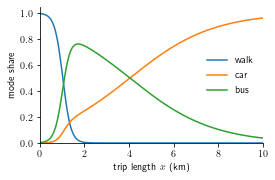

In [65]:
fig,ax = plt.subplots(figsize=(4,2.5))
xarr = np.linspace(0.01, R, 200)
for (fun,mode) in [(Dw,'walk'),(Dc,'car'),(Db,'bus')]:
    ax.plot(xarr,fun(xarr,sQ),label=mode)
ax.legend(frameon=False);ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlim([0,R])

ax.set_ylabel(r"mode share"); ax.set_xlabel(r"trip length $x$ (km)")
print(sQ, sK, (sK - sQ)*100/sQ)
pd.DataFrame({'b':[Q(sK),Q(sQ)], 'c':[Qc(sK),Qc(sQ)],'w':[Qw(sK),Qw(sQ)]})/(R*rho)
tikzplotlib.save('mode-share-nohw.tex',figure=fig,standalone=True,axis_width='8cm',axis_height='6cm')

In [ ]:
print(np.array([sQ, sK, (sK - sQ)*100/sQ]))
print('mode shares\n',pd.DataFrame({'b':[Q(sK),Q(sQ)], 'c':[Qc(sK),Qc(sQ)],'w':[Qw(sK),Qw(sQ)]})/(R*rho))
s0 = sK
print('buses {:.3f}'.format(B(s0)))
print('bus load {:.4f}'.format(K(s0)*H/R))
print('demand {:.1f}'.format(Q(s0)))
print('speed {:.1f}'.format( 1/U(s0,Q(s0))))
print('min per kim {:.1f}'.format(U(s0,Q(s0))*60))
print(H/R*theta*Q(s0)*60)
print(gamma/s0*60)
print('average trip length {:.2f}'.format(K(s0)/Q(s0)))

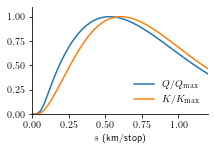

In [4]:
fig,ax = plt.subplots(figsize=(8/intocm,5/intocm))
sarr = np.linspace(0.01, 1.2, 50)
Qarr = Q(sarr)
Karr = K(sarr)
ax.plot(sarr, Qarr/max(Qarr), label  = r'$Q/Q_{\max}$')
ax.plot(sarr, Karr/max(Karr), label  = r'$K/K_{\max}$')
ax.set_xlim(0, sarr[-1])
ax.set_ylim(0, 1.1)
ax.legend(frameon=False);ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
ax.set_xlabel(r'$s$ (km/stop)')
tikzplotlib.save('qk-nohw.tex',figure=fig,standalone=True,axis_width='8cm',axis_height='5cm')

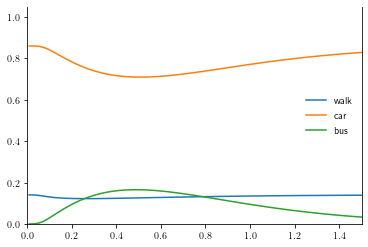

In [17]:
fig,ax = plt.subplots()
sarr = np.linspace(0.01, 1.5, 100)
for (fun,mode) in [(Dw,'walk'),(Dc,'car'),(Db,'bus')]:
    ps = [quad(lambda x: fun(x,s),0,R)[0]/R for s in sarr]
    ax.plot(sarr,ps,label=mode)
ax.set_ylim(0,1.05)
ax.set_xlim(0,sarr[-1])
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)